# **install packages**

In [1]:
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 44kB/s 


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Activation, Reshape, Convolution2D, BatchNormalization
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
import numpy as np
import cv2
import glob
import itertools
import matplotlib.pyplot as plt
import random
import math

In [3]:
tf.__version__

'2.3.1'

# **Maxpooling with argmax and MaxUnpooling layer**

In [4]:
class MaxPoolingWithArgmax2D(Layer):

    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        ksize = [1, pool_size[0], pool_size[1], 1]
        padding = padding.upper()
        strides = [1, strides[0], strides[1], 1]
        output, argmax = tf.nn.max_pool_with_argmax(
            inputs,
            ksize=ksize,
            strides=strides,
            padding=padding)
        
        argmax = K.cast(argmax, K.floatx())
        argmax = tf.stop_gradient(argmax)
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [ dim // ratio[idx] if dim is not None else None for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]

In [5]:
class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with tf.name_scope(self.name):
            mask = tf.cast(mask, 'int32')
            input_shape = updates.get_shape()
            # This statement is required if I don't want to specify a batch size
            if input_shape[0] == None:
                batches = 1
            else:
                batches = input_shape[0]
            #  calculation new shape
            if output_shape is None:
                output_shape = (
                        batches,
                        input_shape[1]*self.size[0],
                        input_shape[2]*self.size[1],
                        input_shape[3])

            # calculation indices for batch, height, width and feature maps
            one_like_mask = tf.ones_like(mask, dtype='int32')
            batch_tensor = tf.range(batches, dtype='int32')
            batch_range = tf.reshape(batch_tensor, shape=[-1, 1 ,1, 1])
            b = one_like_mask * batch_range
            y = mask // (output_shape[2] * output_shape[3])
            x = (mask // output_shape[3]) % output_shape[2]
            feature_range = tf.range(output_shape[3], dtype='int32')
            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = tf.size(updates)
            indices = tf.transpose(tf.reshape( tf.stack([b, y, x, f]), [4, updates_size]))
            values = tf.reshape(updates, [updates_size])
            ret = tf.scatter_nd(indices, values, output_shape)
            return ret
    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.size[0],
            mask_shape[2] * self.size[1],
            mask_shape[3],
        )

In [6]:
tf.executing_eagerly()

True

# **Segnet**

In [7]:
def segnet(
        input_shape,
        n_labels,
        kernel=3,
        pool_size=(2, 2),
        output_mode="softmax"):
    # encoder
    inputs = Input(shape=input_shape)

    conv_1 = Convolution2D(64, (kernel, kernel), padding="same")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Convolution2D(64, (kernel, kernel), padding="same")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)

    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size)(conv_2)

    conv_3 = Convolution2D(128, (kernel, kernel), padding="same")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(128, (kernel, kernel), padding="same")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size)(conv_4)

    conv_5 = Convolution2D(256, (kernel, kernel), padding="same")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(256, (kernel, kernel), padding="same")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Convolution2D(256, (kernel, kernel), padding="same")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)

    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size)(conv_7)

    conv_8 = Convolution2D(512, (kernel, kernel), padding="same")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Convolution2D(512, (kernel, kernel), padding="same")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Convolution2D(512, (kernel, kernel), padding="same")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)

    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size)(conv_10)

    conv_11 = Convolution2D(512, (kernel, kernel), padding="same")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Convolution2D(512, (kernel, kernel), padding="same")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Convolution2D(512, (kernel, kernel), padding="same")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)

    pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size)(conv_13)
    print("Build encoder done..")
    # decoder

    unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])

    conv_14 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Convolution2D(512, (kernel, kernel), padding="same")(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Convolution2D(512, (kernel, kernel), padding="same")(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)

    unpool_2 = MaxUnpooling2D(pool_size)([conv_16, mask_4])

    conv_17 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Convolution2D(512, (kernel, kernel), padding="same")(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Convolution2D(256, (kernel, kernel), padding="same")(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])

    conv_20 = Convolution2D(256, (kernel, kernel), padding="same")(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Convolution2D(256, (kernel, kernel), padding="same")(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Convolution2D(128, (kernel, kernel), padding="same")(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)

    unpool_4 = MaxUnpooling2D(pool_size)([conv_22, mask_2])

    conv_23 = Convolution2D(128, (kernel, kernel), padding="same")(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Convolution2D(64, (kernel, kernel), padding="same")(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])

    conv_25 = Convolution2D(64, (kernel, kernel), padding="same")(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Convolution2D(n_labels, (1, 1), padding="valid")(conv_25)
    conv_26 = BatchNormalization()(conv_26)
    conv_26 = Reshape(
            (input_shape[0]*input_shape[1], n_labels),
            input_shape=(input_shape[0], input_shape[1], n_labels))(conv_26)

    outputs = Activation(output_mode)(conv_26)
    print("Build decoder done..")

    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model

# **load batches**

In [8]:
def getImageArr(im):

    img = im.astype(np.float32)

    img[:, :, 0] -= 103.939
    img[:, :, 1] -= 116.779
    img[:, :, 2] -= 123.68

    return img

In [9]:
def getSegmentationArr(seg, nClasses, input_height, input_width):

    seg_labels = np.zeros((input_height, input_width, nClasses))

    for c in range(nClasses):
        seg_labels[:, :, c] = (seg == c).astype(int)

    seg_labels = np.reshape(seg_labels, (-1, nClasses))
    return seg_labels

In [10]:
def imageSegmentationGenerator(images_path, segs_path, batch_size, n_classes, input_height, input_width):

    assert images_path[-1] == '/'
    assert segs_path[-1] == '/'

    images = sorted(glob.glob(images_path + "*.jpg") + glob.glob(images_path + "*.png") + glob.glob(images_path + "*.jpeg"))

    segmentations = sorted(glob.glob(segs_path + "*.jpg") + glob.glob(segs_path + "*.png") + glob.glob(segs_path + "*.jpeg"))

    zipped = itertools.cycle(zip(images, segmentations))

    while True:
        X = []
        Y = []
        for _ in range(batch_size):
            im, seg = zipped.__next__()
            im = cv2.imread(im, 1)
            seg = cv2.imread(seg, 0)

            assert im.shape[:2] == seg.shape[:2]
            assert im.shape[0] >= input_height and im.shape[1] >= input_width

            # cut the image to the shape of (h, w ,c)
            xx = random.randint(0, im.shape[0] - input_height)
            yy = random.randint(0, im.shape[1] - input_width)

            im = im[xx:xx + input_height, yy:yy + input_width]
            seg = seg[xx:xx + input_height, yy:yy + input_width]

            X.append(getImageArr(im))
            Y.append(getSegmentationArr( seg, n_classes, input_height, input_width))

        yield np.array(X), np.array(Y)

In [11]:
def getTrainSet(images_path, segs_path, n_classes, input_height, input_width):
    assert images_path[-1] == '/'
    assert segs_path[-1] == '/'

    images = sorted(glob.glob(images_path + "*.jpg") + glob.glob(images_path + "*.png") + glob.glob(images_path + "*.jpeg"))

    segmentations = sorted(glob.glob(segs_path + "*.jpg") + glob.glob(segs_path + "*.png") + glob.glob(segs_path + "*.jpeg"))

    zipped = itertools.cycle(zip(images, segmentations))

    X = []
    Y = []
    for i, s in zip(images, segmentations):
        print('image nameL: ', i)
        im = cv2.imread(i, 1)
        seg = cv2.imread(s, 0)

        assert im.shape[:2] == seg.shape[:2]
        assert im.shape[0] >= input_height and im.shape[1] >= input_width

        # cut the image to the shape of (h, w ,c)
        xx = random.randint(0, im.shape[0] - input_height)
        yy = random.randint(0, im.shape[1] - input_width)

        im = im[xx:xx + input_height, yy:yy + input_width]
        seg = seg[xx:xx + input_height, yy:yy + input_width]

        X.append(getImageArr(im))
        Y.append(getSegmentationArr( seg, n_classes, input_height, input_width))

    return np.array(X), np.array(Y)

# **train preprocess: set parameters and create model**

set parameters

In [19]:
train_images_path = "/content/drive/MyDrive/dataset-FCN/images_prepped_train/"
train_segs_path = "/content/drive/MyDrive/dataset-FCN/annotations_prepped_train/"
train_batch_size = 1
n_classes = 11

epochs = 500

input_height = 320
input_width = 320


val_images_path = "/content/drive/MyDrive/dataset-FCN/images_prepped_test/"
val_segs_path = "/content/drive/MyDrive/dataset-FCN/annotations_prepped_test/"
val_batch_size = 1

In [13]:
model = segnet((input_height, input_width, 3), n_classes)

Build encoder done..
Build decoder done..


In [14]:
model.compile(loss='categorical_crossentropy', optimizer="adadelta", metrics=['acc'])

In [20]:
G = imageSegmentationGenerator(train_images_path, train_segs_path, train_batch_size, n_classes=n_classes, input_height=input_height, input_width=input_width)
G_test = imageSegmentationGenerator(val_images_path, val_segs_path, val_batch_size, n_classes=n_classes, input_height=input_height, input_width=input_width)

In [ ]:
# train_x, train_y = getTrainSet(train_images_path, train_segs_path, n_classes=n_classes, input_height=input_height, input_width=input_width)

Epoch 1/500
367/367 [==============================] - 60s 163ms/step - loss: 2.1166 - acc: 0.2555 - val_loss: 2.1034 - val_acc: 0.2578
Epoch 2/500
367/367 [==============================] - 61s 165ms/step - loss: 2.0368 - acc: 0.2837 - val_loss: 2.0138 - val_acc: 0.3061
Epoch 3/500
367/367 [==============================] - 55s 151ms/step - loss: 1.9711 - acc: 0.3129 - val_loss: 1.9569 - val_acc: 0.3364
Epoch 4/500
367/367 [==============================] - 61s 165ms/step - loss: 1.9239 - acc: 0.3427 - val_loss: 1.8987 - val_acc: 0.3564
Epoch 5/500
367/367 [==============================] - 58s 159ms/step - loss: 1.8792 - acc: 0.3718 - val_loss: 1.8428 - val_acc: 0.3682
Epoch 6/500
367/367 [==============================] - 59s 160ms/step - loss: 1.8504 - acc: 0.3976 - val_loss: 1.7815 - val_acc: 0.4520
Epoch 7/500
367/367 [==============================] - 62s 170ms/step - loss: 1.8169 - acc: 0.4206 - val_loss: 1.7941 - val_acc: 0.4172
Epoch 8/500
367/367 [===========================

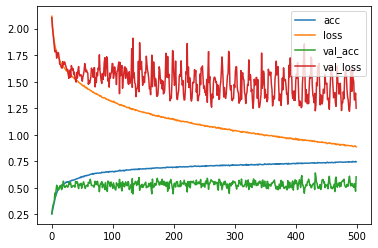

In [26]:
history = model.fit_generator(generator=G,
                steps_per_epoch=math.ceil(367. / train_batch_size),
                
                epochs=epochs,
                verbose=1,
                validation_data=G_test,
                validation_steps=8,
                shuffle=True)

model.save_weights('/content/drive/MyDrive/segnetnet_final.h5')


acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
x = list(range(len(acc)))
plt.plot(x, acc, label='acc')
plt.plot(x, loss, label='loss')
plt.plot(x, val_acc, label='val_acc')
plt.plot(x, val_loss, label='val_loss')
plt.legend()
plt.show()

# **previous training steps**

In [ ]:
model.save_weights('/content/drive/MyDrive/segnet.h5')

In [ ]:
model.fit(train_x, train_y, batch_size=1, epochs=100, verbose=1, shuffle=True)

Epoch 1/100
367/367 [==============================] - 24s 66ms/step - loss: 1.3711 - acc: 0.6111
Epoch 2/100
367/367 [==============================] - 24s 66ms/step - loss: 1.2370 - acc: 0.6539
Epoch 3/100
367/367 [==============================] - 24s 66ms/step - loss: 1.1424 - acc: 0.6835
Epoch 4/100
367/367 [==============================] - 24s 66ms/step - loss: 1.0644 - acc: 0.7090
Epoch 5/100
367/367 [==============================] - 24s 66ms/step - loss: 0.9977 - acc: 0.7324
Epoch 6/100
367/367 [==============================] - 24s 66ms/step - loss: 0.9429 - acc: 0.7521
Epoch 7/100
367/367 [==============================] - 24s 66ms/step - loss: 0.8982 - acc: 0.7683
Epoch 8/100
367/367 [==============================] - 24s 66ms/step - loss: 0.8599 - acc: 0.7826
Epoch 9/100
367/367 [==============================] - 24s 66ms/step - loss: 0.8281 - acc: 0.7952
Epoch 10/100
367/367 [==============================] - 24s 66ms/step - loss: 0.8013 - acc: 0.8054
Epoch 11/100
367/36

In [ ]:
model.save_weights('/content/drive/MyDrive/segnet_12_3_100epoch.h5')

In [ ]:
model.fit(train_x, train_y, batch_size=1, epochs=100, verbose=1, shuffle=True)
model.save_weights('/content/drive/MyDrive/segnet_12_3_200epoch.h5')

Epoch 1/100
367/367 [==============================] - 24s 65ms/step - loss: 0.5280 - acc: 0.8992
Epoch 2/100
367/367 [==============================] - 24s 66ms/step - loss: 0.5284 - acc: 0.8987
Epoch 3/100
367/367 [==============================] - 26s 70ms/step - loss: 0.5276 - acc: 0.8987
Epoch 4/100
367/367 [==============================] - 24s 66ms/step - loss: 0.5255 - acc: 0.8996
Epoch 5/100
367/367 [==============================] - 24s 66ms/step - loss: 0.5248 - acc: 0.8998
Epoch 6/100
367/367 [==============================] - 24s 67ms/step - loss: 0.5237 - acc: 0.9001
Epoch 7/100
367/367 [==============================] - 24s 66ms/step - loss: 0.5231 - acc: 0.9000
Epoch 8/100
367/367 [==============================] - 24s 66ms/step - loss: 0.5226 - acc: 0.9000
Epoch 9/100
367/367 [==============================] - 24s 66ms/step - loss: 0.5213 - acc: 0.9003
Epoch 10/100
367/367 [==============================] - 25s 67ms/step - loss: 0.5210 - acc: 0.9004
Epoch 11/100
367/36

In [ ]:
model.fit(train_x, train_y, batch_size=1, epochs=100, verbose=1, shuffle=True)
model.save_weights('/content/drive/MyDrive/segnet_12_3_300epoch.h5')

Epoch 1/100
367/367 [==============================] - 24s 66ms/step - loss: 0.4606 - acc: 0.9109
Epoch 2/100
367/367 [==============================] - 24s 65ms/step - loss: 0.4608 - acc: 0.9106
Epoch 3/100
367/367 [==============================] - 24s 66ms/step - loss: 0.4593 - acc: 0.9110
Epoch 4/100
367/367 [==============================] - 24s 66ms/step - loss: 0.4581 - acc: 0.9115
Epoch 5/100
367/367 [==============================] - 24s 65ms/step - loss: 0.4580 - acc: 0.9115
Epoch 6/100
367/367 [==============================] - 24s 65ms/step - loss: 0.4578 - acc: 0.9111
Epoch 7/100
367/367 [==============================] - 24s 65ms/step - loss: 0.4568 - acc: 0.9115
Epoch 8/100
367/367 [==============================] - 24s 65ms/step - loss: 0.4561 - acc: 0.9118
Epoch 9/100
367/367 [==============================] - 24s 66ms/step - loss: 0.4563 - acc: 0.9114
Epoch 10/100
367/367 [==============================] - 24s 65ms/step - loss: 0.4557 - acc: 0.9115
Epoch 11/100
367/36

In [ ]:
model.fit(train_x, train_y, batch_size=1, epochs=200, verbose=1, shuffle=True)
model.save_weights('/content/drive/MyDrive/segnet_12_3_500epoch.h5')

Epoch 1/200
367/367 [==============================] - 24s 67ms/step - loss: 0.4124 - acc: 0.9177
Epoch 2/200
367/367 [==============================] - 24s 67ms/step - loss: 0.4118 - acc: 0.9178
Epoch 3/200
367/367 [==============================] - 24s 66ms/step - loss: 0.4115 - acc: 0.9177
Epoch 4/200
367/367 [==============================] - 24s 66ms/step - loss: 0.4111 - acc: 0.9178
Epoch 5/200
367/367 [==============================] - 24s 66ms/step - loss: 0.4102 - acc: 0.9182
Epoch 6/200
367/367 [==============================] - 24s 67ms/step - loss: 0.4093 - acc: 0.9184
Epoch 7/200
367/367 [==============================] - 24s 66ms/step - loss: 0.4093 - acc: 0.9182
Epoch 8/200
367/367 [==============================] - 24s 66ms/step - loss: 0.4088 - acc: 0.9184
Epoch 9/200
367/367 [==============================] - 24s 66ms/step - loss: 0.4086 - acc: 0.9183
Epoch 10/200
367/367 [==============================] - 24s 66ms/step - loss: 0.4082 - acc: 0.9184
Epoch 11/200
367/36

# **demo predict**

In [ ]:
input_height = 320
input_width = 320
n_classes = 11
model = segnet((input_height, input_width, 3), n_classes)
model.load_weights('/content/drive/MyDrive/segnet_12_3_500epoch.h5')

Build encoder done..
Build decoder done..


In [ ]:
images_path = "/content/drive/MyDrive/dataset-FCN/images_prepped_train/"
segs_path = "/content/drive/MyDrive/dataset-FCN/annotations_prepped_train/"

In [ ]:
colors = [ (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in range(n_classes)]


In [ ]:
def label2color(colors, n_classes, seg):
    """
    inputs: 
            colors: a map from class_label to a specific color
            n_classes:
            seg: predict result: (b, h * w, n_classes)
    output:
        seg_color: (b, h * w, 3)
    """
    seg_color = np.zeros((seg.shape[0], seg.shape[1], 3))
    for c in range(n_classes):
        seg_color[:, :, 0] += ((seg == c) * (colors[c][0])).astype('uint8')
        seg_color[:, :, 1] += ((seg == c) * (colors[c][1])).astype('uint8')
        seg_color[:, :, 2] += ((seg == c) * (colors[c][2])).astype('uint8')
    seg_color = seg_color.astype(np.uint8)
    return seg_color

In [ ]:
def getcenteroffset(shape, input_height, input_width):
    short_edge = min(shape[:2])
    xx = int((shape[0] - short_edge) / 2)
    yy = int((shape[1] - short_edge) / 2)
    return xx, yy

In [ ]:
images = sorted(glob.glob( images_path + "*.jpg") + glob.glob( images_path + "*.png") + glob.glob( images_path + "*.jpeg"))
segmentations = sorted(glob.glob(segs_path + "*.jpg") + glob.glob(segs_path + "*.png") + glob.glob(segs_path + "*.jpeg"))

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
for i, (imgName, segName) in enumerate(zip(images, segmentations)):

    print("%d/%d %s" % (i + 1, len(images), imgName))

    im = cv2.imread(imgName, 1)
    xx, yy = getcenteroffset(im.shape, input_height, input_width)
    im = im[xx:xx + input_height, yy:yy + input_width, :]

    seg = cv2.imread(segName, 0)
    seg = seg[xx:xx + input_height, yy:yy + input_width]

    pr = model.predict(np.expand_dims(getImageArr(im), 0))[0]
    pr = pr.reshape((input_height, input_width, n_classes)).argmax(axis=2)

    cv2_imshow(im)
    cv2_imshow(label2color(colors, n_classes, pr))
    cv2_imshow(label2color(colors, n_classes, seg))

    cv2.waitKey()

Output hidden; open in https://colab.research.google.com to view.